# 4-FAST, because 3-FAST got too cluttered
(And i probably added a stupid bug again)

Here I want to make nice plots for the $\tilde T$ QuadOsc style and also calculate the full projected matter densities $w_{\ell}$ using QuadOsc. In addition, I'll try to look more into the $w$s with a $\chi$ evolution. Once that is done, I'll move onto the $C_{\ell}$ computation.

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using TwoFAST
using Dierckx
using DelimitedFiles
using QuadOsc
using FunctionZeros
using TwoFAST

In [3]:
using Revise
using Will

## Interpolate N5K stuff

In [4]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
# THAT'S THE NEW INTERPOLATION SCHEME!!!
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

In [8]:
ℓ = 100.0
lidx = 24
R = 0.5
R_label = "05"
npzread("ell_vector.npy")[lidx]

100.0

### Chebyshev coefficients
For how I'm calculating the $\tilde T$ QuadOsc style, the interpolation is no longer in $log(k_{min})-log(k_{max})$ but in $k_{min}-k_{max}$. FOR NOW no $\chi$ evolution.

In [71]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 128
nχ = 100
χ = LinRange(26, 7000, nχ)
χ_list = LinRange(26, 7000, 10)
fix_chi = χ_list[7]
χ_fixed = χ_list[7];

k_cheb = chebpoints(n_cheb, kmin, kmax)
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(k_cheb, fix_chi, fix_chi), kmin, kmax); 
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

In [72]:
function load_Ts(folder)
    ell_vector = npzread("ell_vector.npy") 
    full_T = zeros(26, 100, 100, 129)
    for i in 1:26
        l_string = string(round(ell_vector[i]; digits=1))
        filename = folder * "/T_tilde_l_$l_string.npy"
        if isfile(filename)
            full_T[i,:,:,:] = npzread(filename)
        else
            full_T[i,:,:,:] = zeros(30,30,129)
        end
    end
    return full_T
end

load_Ts (generic function with 1 method)

#### THE $\tilde T$ THAT ARE AVAILABLE NOW WITH THIS METHOD ARE THE ONES WITH R = 1, 0.9, 0.75

In [11]:
T_LL = load_Ts("T_validation/RR_$(R_label)_LL")
T_CL = load_Ts("T_validation/RR_$(R_label)_CL")
T_CC = load_Ts("T_validation/RR_$(R_label)_CC")

w_LL = Will.w_ell_tullio(coeff, T_LL)
w_CL = Will.w_ell_tullio(coeff, T_CL)
w_CC = Will.w_ell_tullio(coeff, T_CC);

### Functions

In [12]:
function calculate_2FAST(chi_array, label, ℓ, RR, power_spectrum)
    N = 30000
    chi0 = 0.001
    kmax = 1e7
    kmin = 1e-5
    ell = [Int(ℓ)] 
    RR = [RR]

    if label == "LL"
        q = -2.5
        idx = 4
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end
    

    # calculate M_ll at high ell, result gets saved to a file:
    f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
    write("out/F21EllCache", f21cache)

    # calculate all M_ll, result gets saved to a file:
    mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
    write("out/MlCache", mlcache)

    w00 = Array{Float64}(undef, N, length(RR))
    function outfunc(wjj, ell, rr, RR)
        w00[:,:] = wjj[1]
    end
    rr = calcwljj(x->power_spectrum(x, fix_chi, fix_chi)/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
    interp= Spline1D(rr, w00[:,1]) 
    w00_interp = interp.(chi_array)*π/2
    
    return w00_interp
end;      

In [13]:
function move(nf, ng, zerosf, zerosg)
    zerof = zerosf(nf)
    zerog = zerosg(ng)
    if zerof < zerog
        nf += 1
        zerofg = zerof
    elseif zerof > zerog
        ng += 1
        zerofg = zerog
    elseif zerof == zerog
        nf += 1
        ng += 1
        zerofg = zerof
    else
        @warn "Something bad happened!"
    end
    return zerofg, nf, ng
end

function nzeros_two_function(n, zerosf::Function, zerosg::Function)
    nf = 1
    ng = 1
    zerofg = 0.
    for i in 1:n
        zerofg, nf, ng = move(nf, ng, zerosf, zerosg)
    end
    return zerofg
end;

In [14]:
function calc_qosc(χ_list, label, ℓ, RR, fix, power_spectrum)

    if label == "LL"
        idx = -2
    elseif label == "CL"
        idx = 0 
    elseif label == "CC"
        idx = 2
    end
    
    result_Ia = zeros(length(χ_list))

    if fix == false
        @time for i in 1:length(χ_list)
            println("Processing QuadOsc for χ = $(χ_list[i])")
            first_bessel(n) = besselj_zero(ℓ+0.5, n)/(χ_list[i])
            second_bessel(n) = besselj_zero(ℓ+0.5, n)/(RR*χ_list[i])
            Ia, Ea = quadosc(x->power_spectrum(x, χ_list[i], RR*χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)*Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx), kmin, Inf,n->nzeros_two_function(n, first_bessel, second_bessel))
            result_Ia[i] = Ia
        end
    elseif fix == true
        @time for i in 1:length(χ_list)
            println("Processing QuadOsc for χ = $(χ_list[i])")
            first_bessel(n) = besselj_zero(ℓ+0.5, n)/(χ_list[i])
            second_bessel(n) = besselj_zero(ℓ+0.5, n)/(RR*χ_list[i])
            Ia, Ea = quadosc(x->power_spectrum(x, fix_chi, fix_chi)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)*Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx), kmin, Inf,  n->nzeros_two_function(n, first_bessel, second_bessel))            
            result_Ia[i] = Ia
        end
    end
    return result_Ia
end;

In [15]:
function cheby_zero(k)
    if k == 1 
        return kmin
    end
    zero_cheby = []
    for i in 0:(k-2)
        z = cos.(π*(i+0.5)/(k-1))
        z = (kmax - kmin) / 2 * z .+ (kmin + kmax) / 2
        push!(zero_cheby, z)
    end
    reverse!(zero_cheby)
    return zero_cheby
end

cheby_zero (generic function with 1 method)

In [16]:
function T̃_qosc_style(pk, ℓ, χ_list, R, kmin, kmax, tracers)
    n_cheb = 128
    N = 2^14
    x = FastTransforms.clenshawcurtisnodes(Float64, N)
    x = (kmax - kmin) / 2 * x .+ (kmin + kmax) / 2
    k_cheb = chebpoints(n_cheb, minimum(minimum.(x)), maximum(maximum.(x)));
    c = chebinterp( pk(k_cheb,fix_chi,fix_chi), minimum(minimum.(x)), maximum(maximum.(x)))
    α_k = 2
    T = zeros(1, length(χ_list), length(χ_list), n_cheb+1 )

    if tracers == "CC"
        idx = 2
    elseif tracers == "CL"
        idx = 0 
    elseif tracers == "LL"
        idx = -2
    end

    for (aidx, a) in enumerate(χ_list)
        println("Processing χ = $a...")
        for i in 1:n_cheb+1
            copy_c = deepcopy(c) #copio l'interpolante
            copy_c.coefs .*= 0 #azzero i coeff del polinomio
            copy_c.coefs[i] = 1.
    
            #find zeros of the bessels functions. they're always the same.
            zero_list = [kmin]
            actual_zero = 0.
            n = 1
            while actual_zero < α_k*kmax#add zeroes first function
                actual_zero = besselj_zero(ℓ+0.5, n)/(a)
                n +=1 
                push!(zero_list, actual_zero)
            end
            
            actual_zero = 0.
            n = 1
            while actual_zero < α_k*kmax#add zeroes second function
                actual_zero = besselj_zero(ℓ+0.5, n)/(a*R)
                n +=1 
                push!(zero_list, actual_zero)
            end
    
            chebz = cheby_zero(i)
    
            for j in 1:length(chebz)
                push!(zero_list, chebz[j])
            end
    
            sort!(unique!(zero_list))
            
            push!(zero_list, kmax)
            zero_list = @. zero_list[zero_list<=kmax]
    
            results_to_sum = zeros(length(zero_list)-1)
            f(x) = copy_c(x)*Bessels.sphericalbesselj(ℓ, a*x)*Bessels.sphericalbesselj(ℓ, a*R*x) *(x^idx)
            Threads.@threads for myi in 1:length(zero_list)-1
            I, _ = quadgk(x-> f(x), zero_list[myi], zero_list[myi+1]; atol=zero(Float64), rtol=sqrt(eps(Float64)), order=9)
            results_to_sum[myi] = I
            end
    
            T[1, aidx, aidx, i] = sum(sort(results_to_sum))
        end
    end
    return T
end;

## LL

In [17]:
w_LL_2F = calculate_2FAST(χ, "LL", ℓ, R, power_spectrum);

  q=-2.5, R=0.5:	  0.264186 seconds (1.60 M allocations: 249.328 MiB, 11.69% gc time, 8.55% compilation time)

ℓ = 100
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = -2.5
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006991 seconds (182 allocations: 638.156 KiB)
ellmax: 102
lmaxcache: 100
fell[:,1,1] = ComplexF64[8.364216565128888e-63 + 0.0im, 8.370727157989027e-63 + 0.0im]
ell 102, elapsed: 2.9087066650390625e-5
ell 101, elapsed: 0.30927395820617676
ell 100, elapsed: 0.003997087478637695
ell 99, elapsed: 0.0010530948638916016
ell 98, elapsed: 0.0010480880737304688
  0.338287 seconds (454.89 k allocations: 30.509 MiB, 98.50% compilation time)
elapsed: 0.0014939308166503906
step:          0.089572 sec (107.51 k allocations: 7.591 MB, 0.0% gc time)
swapping:      3.0e-6 sec (0 

In [18]:
w_LL_qosc = calc_qosc(χ, "LL", ℓ, R, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 266.48275862068965
Processing QuadOsc for χ = 506.9655172413793
Processing QuadOsc for χ = 747.448275862069
Processing QuadOsc for χ = 987.9310344827586
Processing QuadOsc for χ = 1228.4137931034481
Processing QuadOsc for χ = 1468.896551724138
Processing QuadOsc for χ = 1709.3793103448277
Processing QuadOsc for χ = 1949.8620689655172
Processing QuadOsc for χ = 2190.344827586207
Processing QuadOsc for χ = 2430.8275862068963
Processing QuadOsc for χ = 2671.310344827586
Processing QuadOsc for χ = 2911.793103448276
Processing QuadOsc for χ = 3152.2758620689656
Processing QuadOsc for χ = 3392.7586206896553
Processing QuadOsc for χ = 3633.241379310345
Processing QuadOsc for χ = 3873.7241379310344
Processing QuadOsc for χ = 4114.206896551724
Processing QuadOsc for χ = 4354.689655172414
Processing QuadOsc for χ = 4595.172413793103
Processing QuadOsc for χ = 4835.655172413793
Processing QuadOsc for χ = 5076.137931034483
Processing QuadO

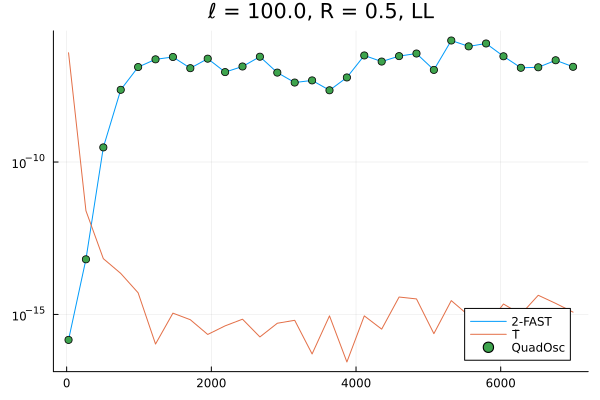

In [19]:
plot(χ, abs.(w_LL_2F), label="2-FAST", title = "ℓ = $ℓ, R = $R, LL")
plot!(χ, abs.(diag(w_LL[lidx,:,:])), label="T̃", yscale=:log10)
scatter!(χ, abs.(w_LL_qosc), label="QuadOsc", legend=:bottomright)

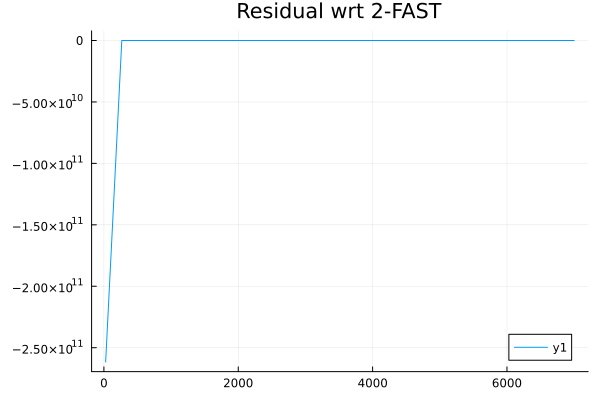

In [20]:
plot(χ, 100*(1 .- (diag(w_LL[lidx,:,:]) ./ w_LL_2F)), title = "Residual wrt 2-FAST")

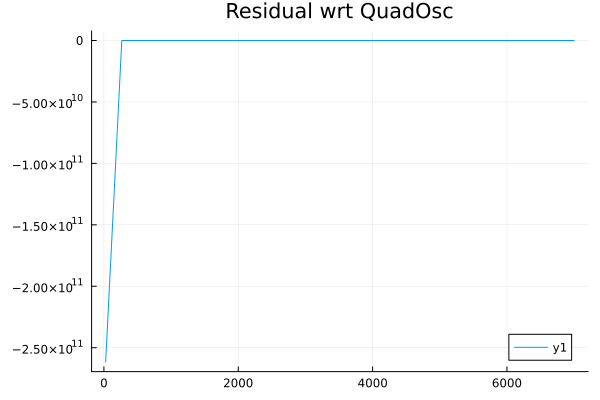

In [21]:
plot(χ, 100*(1 .- (diag(w_LL[lidx,:,:]) ./ w_LL_qosc)), title = "Residual wrt QuadOsc")

## CL

In [ ]:
w_CL_2F = calculate_2FAST(χ, "CL", ℓ, R, power_spectrum)
w_CL_qosc = calc_qosc(χ, "CL", ℓ, R, true, power_spectrum);

  q=0.5, R=0.5:	  0.310669 seconds (1.59 M allocations: 248.970 MiB, 21.47% gc time)

ℓ = 100
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 0.5
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.004402 seconds (180 allocations: 638.023 KiB)
ellmax: 102
lmaxcache: 100
fell[:,1,1] = ComplexF64[-2.6136515865439817e-35 + 3.20080004954749e-51im, -2.627961072119105e-35 + 3.218324115254509e-51im]
ell 102, elapsed: 3.4809112548828125e-5
ell 101, elapsed: 0.00043320655822753906
ell 100, elapsed: 0.0002429485321044922
ell 99, elapsed: 0.0010402202606201172
ell 98, elapsed: 0.0010349750518798828
  0.004439 seconds (339 allocations: 19.727 KiB)
elapsed: 0.0014350414276123047
step:          0.000372 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.

In [ ]:
plot(χ, abs.(w_CL_2F), label="2-FAST", title = "ℓ = $ℓ, R = $R, CL")
plot!(χ, abs.(diag(w_CL[lidx,:,:])), label="T̃", yscale=:log10, xscale =:log10)
scatter!(χ, abs.(w_CL_qosc), label="QuadOsc", legend=:topright)

In [ ]:
plot(χ, 100*(1 .- (diag(w_CL[lidx,:,:]) ./ w_CL_2F)), title = "Residual wrt 2-FAST")

In [ ]:
plot(χ, 100*(1 .- (diag(w_CL[lidx,:,:]) ./ w_CL_qosc)), title = "Residual wrt QuadOsc")

## CC

In [31]:
w_CC_2F = calculate_2FAST(χ, "CC", ℓ, R, power_spectrum)
w_CC_qosc = calc_qosc(χ, "CC", ℓ, R, true, power_spectrum);

  q=1.1, R=0.5:	  0.240594 seconds (1.59 M allocations: 248.826 MiB, 23.47% gc time)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 1.1
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.004086 seconds (180 allocations: 638.023 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[0.00024259378126925295 - 5.941833954488794e-20im, 0.00024888650691705686 - 6.095961280938699e-20im]
ell 22, elapsed: 3.1948089599609375e-5
ell 21, elapsed: 0.0004150867462158203
ell 20, elapsed: 0.00025010108947753906
ell 19, elapsed: 0.0011491775512695312
ell 18, elapsed: 0.0010671615600585938
  0.004587 seconds (339 allocations: 19.727 KiB)
elapsed: 0.001455068588256836
step:          0.000379 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      2.0e-6 sec (0 allocations: 0 byte, 0.0% gc t

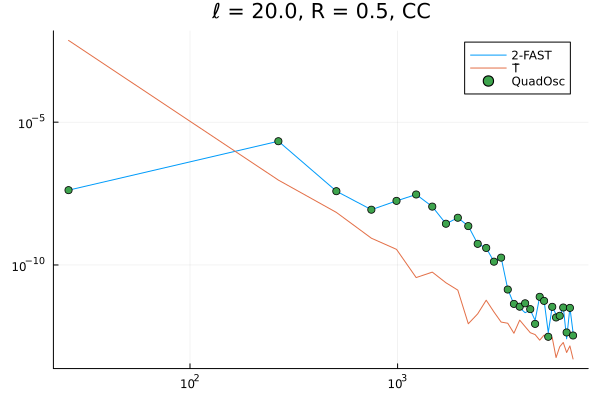

In [32]:
plot(χ, abs.(w_CC_2F), label="2-FAST", title = "ℓ = $ℓ, R = $R, CC")
plot!(χ, abs.(diag(w_CC[lidx,:,:])), label="T̃", yscale=:log10, xscale=:log10)
scatter!(χ, abs.(w_CC_qosc), label="QuadOsc", legend=:topright)

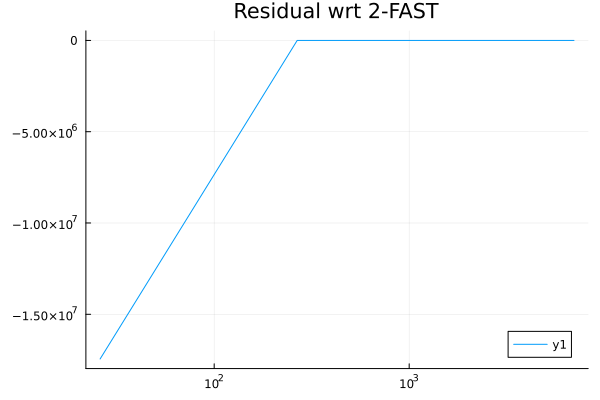

In [33]:
plot(χ, 100*(1 .- (diag(w_CC[lidx,:,:]) ./ w_CC_2F)), title = "Residual wrt 2-FAST", xscale=:log10)

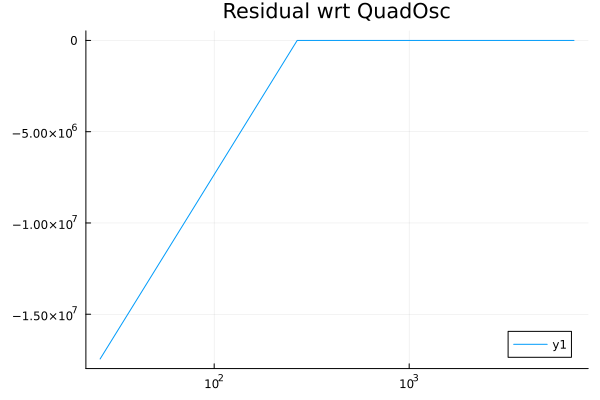

In [34]:
plot(χ, 100*(1 .- (diag(w_CC[lidx,:,:]) ./ w_CC_qosc)), title = "Residual wrt QuadOsc",xscale=:log10)

# Calculating full w with 2-FAST

In [32]:
function build_2FAST_w(chi_array, label, ℓ)
    w_2F = zeros(length(chi_array), length(chi_array))
    N = 30000
    kmin = 1e-5
    kmax = 1e7
    chi0 = 0.00001 
    ell = [Int(ℓ)] 
    #RR = [1.0]

    if label == "LL"
        q = -2.1
        idx = 4
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end

    for i in 1:length(chi_array)
        println("Processing χ1 = $(chi_array[i])")
        for j in i:length(chi_array) 
            RR = [chi_array[i] ./ chi_array[j]]
            if RR[1] .< 0.1
                w_2F[i,j] = 0
                w_2F[j,i] = 0
            else
                #println("R=$(RR)")
                # calculate M_ll at high ell, result gets saved to a file:
                f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
                write("out/F21EllCache", f21cache)
            
                # calculate all M_ll, result gets saved to a file:
                mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
                write("out/MlCache", mlcache)
                # calculate wljj:
                w00 = Array{Float64}(undef, N, length(RR))
                function outfunc(wjj, ell, rr, RR)
                    w00[:,:] = wjj[1]
                end
                rr = calcwljj(x->power_spectrum(x, chi_array[i], chi_array[j])/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
                interp= Spline1D(rr, w00[:,1])
                w00_interp = interp.(chi_array)*π/2
                
                w_2F[i,j] = w00_interp[j]
                w_2F[j,i] = w_2F[i,j]
            end
        end
    end
    return w_2F
end;        

In [141]:
function w_2F_interp(χ1, label, ℓ)
    N = 30000
    kmin = 1e-5
    kmax = 1e7
    chi0 = 0.00001 
    ell = [Int(ℓ)] 
    #RR = [1.0]

    if label == "LL"
        q = -2.1
        idx = 4
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end

    Rs = LinRange(0,1,100)

    w_cR = zeros(length(χ1), length(Rs))
    
    for (rindex, r) in enumerate(Rs)
        println("Processing R = $r")
        RR = [r]
        f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
        write("out/F21EllCache", f21cache)
            
        # calculate all M_ll, result gets saved to a file:
        mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
        write("out/MlCache", mlcache)
        for i in 1:length(χ1)
            # calculate wljj:
            w00 = Array{Float64}(undef, N, length(RR))
            function outfunc(wjj, ell, rr, RR)
                w00[:,:] = wjj[1]
            end
            rr = calcwljj(x->power_spectrum(x, χ1[i], r*χ1[i])/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
            interp= Spline1D(rr, w00[:,1])
            w00_interp = interp.(χ1)*π/2
            w_cR[i,rindex] = w00_interp[i]
        end
    end
    itp = interpolate((χ1,Rs), w_cR, Gridded(Linear()))
    w_interp = zeros(length(χ1),length(χ1))
    for i in 1:length(χ1)
        for j in i:length(χ1)
            χA = χ1[i]
            χB = χ1[j]
            R = χA/χB
            w_interp[i,j] = itp(χA, R)
            w_interp[j,i] = w_interp[i,j]
        end
    end
        
    return w_interp
end

w_2F_interp (generic function with 1 method)

In [144]:
ℓ_2F = [2,20,50,100,200,300]
labels = ["LL", "CL", "CC"]
χ_2F = LinRange(26,7000, 200)

for (labidx, lab) in enumerate(labels)
    for (ellind, ell) in enumerate(ℓ_2F)
        filename = "w_2_FAST/w_$(lab)_l_$(ell).npz"
        if isfile(filename)
            continue
        else
            println("Processing $(lab), ℓ = $ell")
            @time w = w_2F_interp(χ_2F, lab, ell)
            npzwrite(filename, w)
        end
    end
end

Processing CC, ℓ = 2
Processing R = 0.0
Processing R = 0.010101010101010102
Processing R = 0.020202020202020204
Processing R = 0.030303030303030304
Processing R = 0.04040404040404041
Processing R = 0.050505050505050504
Processing R = 0.06060606060606061
Processing R = 0.0707070707070707
Processing R = 0.08080808080808081
Processing R = 0.09090909090909091
Processing R = 0.10101010101010101
Processing R = 0.1111111111111111
Processing R = 0.12121212121212122
Processing R = 0.13131313131313133
Processing R = 0.1414141414141414
Processing R = 0.15151515151515152
Processing R = 0.16161616161616163
Processing R = 0.1717171717171717
Processing R = 0.18181818181818182
Processing R = 0.1919191919191919
Processing R = 0.20202020202020202
Processing R = 0.21212121212121213
Processing R = 0.2222222222222222
Processing R = 0.23232323232323232
Processing R = 0.24242424242424243
Processing R = 0.25252525252525254
Processing R = 0.26262626262626265
Processing R = 0.2727272727272727
Processing R = 0.2

┌ Warning: Assumption may be violated: Result is not close to zero
│   calc_f = (::TwoFAST.Miller.var"#calc_f#3"{typeof(TwoFAST.Miller.calc_fmax_fn), Float64, TwoFAST.var"#BCfn#13"{Float64, Int64, ComplexF64}, Vector{ComplexF64}, Vector{ComplexF64}, Int64}) (generic function with 1 method)
│   nmin = 19
│   nmax = 20
│   fmax =
│    2-element Vector{ComplexF64}:
│     ⋮
│   abs.(fmax) =
│    2-element Vector{Float64}:
│     ⋮
└ @ TwoFAST.Miller ~/Desktop/PhD_Stuff/TwoFAST.jl/src/Miller.jl:218
┌ Warning: Initial value could not be calculated!
│   n = 20
│   n3 = 19
│   ndiffmin = 4
│   BCfn = (::TwoFAST.var"#BCfn#13"{Float64, Int64, ComplexF64}) (generic function with 1 method)
│   f0 = 2-element Vector{ComplexF64}: …
│   fn1 = 2-element Vector{ComplexF64}: …
│   fn2 = 2-element Vector{ComplexF64}: …
│   fn3 = 2-element Vector{ComplexF64}: …
│   fasymp = 2-element Vector{ComplexF64}: …
└ @ TwoFAST.Miller ~/Desktop/PhD_Stuff/TwoFAST.jl/src/Miller.jl:256


Processing R = 0.020202020202020204
Processing R = 0.030303030303030304
Processing R = 0.04040404040404041
Processing R = 0.050505050505050504
Processing R = 0.06060606060606061
Processing R = 0.0707070707070707
Processing R = 0.08080808080808081
Processing R = 0.09090909090909091
Processing R = 0.10101010101010101
Processing R = 0.1111111111111111
Processing R = 0.12121212121212122
Processing R = 0.13131313131313133
Processing R = 0.1414141414141414
Processing R = 0.15151515151515152
Processing R = 0.16161616161616163
Processing R = 0.1717171717171717
Processing R = 0.18181818181818182
Processing R = 0.1919191919191919
Processing R = 0.20202020202020202
Processing R = 0.21212121212121213
Processing R = 0.2222222222222222
Processing R = 0.23232323232323232
Processing R = 0.24242424242424243
Processing R = 0.25252525252525254
Processing R = 0.26262626262626265
Processing R = 0.2727272727272727
Processing R = 0.2828282828282828
Processing R = 0.29292929292929293
Processing R = 0.30303030